# A Trend Analysis of IMDB Ratings
## Can we draw conclusions about the quality of films in a given year, genre or by director with IMDB ratings?

#### Describe your dataset:
<br>
After looking at quite a few datasets for this capstone, I ultimately turned to my passion: films. So, I decided to analyze IMDB film ratings. I want to identify trends in film ratings by year, director, and genres. The IMDB dataset used (which can be found here: https://www.imdb.com/interfaces/) gives me access to these things in a TSV file format, which even though it's not quite a CSV file, I was able to bring it in with the 'pd.read_csv' method we learned in the fundamentals course with a few tweaks. <br>
<br>
Of the 7 files available, I decided to only use 4 of them. Mainly to limit the amount of data I was working with, but also because I found the other files to be superfluous to my main intent of looking at average ratings across films and genres. I looked at all of the data below and found that including the other types of content added a lot of noise into the data, and didn't add anything to the narrative of comparing content over years, genre or directors. So, I filtered out other title types like tv series and tv episodes to just get films. I did include a quick look at ratings by content type, simply to see how movies compare.

In looking at the dataset, there is one issue I will need to solve before I start to analyze the dataset. Genres are sometimes combined, such as "Drama, Fantasy, Sci-Fi." I will need to separate the genres into unique categories before I can start to see how the individual genres compare. 

#### Ask and answer analytic questions:
1. How are average IMDB ratings changing by year? 
2. How are average IMDB ratings changing by genre?<br>
    2b. How are some of the most popular genres' IMDB ratings changing by year?
3. Who are the most popular directors?<br>
    3b. How does a director's experience relate to ratings? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statistics as st
%matplotlib inline
import pylab as pl

In [2]:
#ingest rating dataset, as is
df_ratings = pd.read_csv('title.ratings.tsv.tsv', sep='\t', header=0)

#ingest crew dataset which matches title to directors and writers
#only need unique list of directors
df_crew = pd.read_csv('title.crew.tsv.tsv', sep='\t', header=0)
#df_crew_unq = pd.df_crew({c: df_crew[c].unique() for c in df_crew}) #(for directors)

#ingest title information which includes title name 'primaryTitle', 'genres', and 'startYear'
df_titles = pd.read_csv('title.basics.tsv.tsv', sep='\t', header=0)

# ingest names of people (includes directors which we care about)
df_names = pd.read_csv('name.basics.tsv.tsv', sep='\t', header=0)
# remove all but primary key and name of directors
df_names = df_names[['nconst', 'primaryName']]

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_titles_all = pd.merge(df_titles, df_crew, how='left', on='tconst')
df_titles_all_ratings = pd.merge(df_titles_all, df_ratings, how='left', on='tconst')

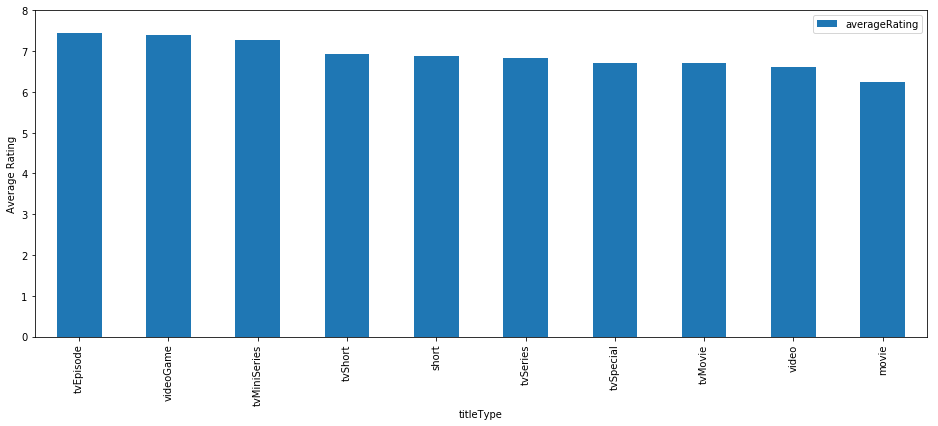

In [4]:
df_titles_type = df_titles_all_ratings[['startYear','titleType','averageRating']].groupby(['titleType'], as_index=True).mean()
a = df_titles_type.sort_values('averageRating', ascending=False).plot(kind='bar', figsize=(16,6))
a.set_ylim(ymin=0, ymax=8)
plt.ylabel('Average Rating')
plt.show()

Just a quick look at how different types of titles perform relative to each other. This analysis will focus on movies, and it is interesting to see that on average they are the lowest rated type of content. 

In [5]:
#join all columns together on tconst (title) or nconst (names)
# remove titletypes not equal to movies, only interested in movies for this analysis
df_titles_mov = pd.merge(df_titles[df_titles['titleType']=='movie'], df_crew, how='left', on='tconst')
df_titles_mov_ratings = pd.merge(df_titles_mov, df_ratings, how='left', on='tconst')
df_IMDB_agg = pd.merge(df_titles_mov_ratings, df_names, how='left', left_on='directors',right_on='nconst')
#remove null values and convert startYear to integer values
df_IMDB_agg = df_IMDB_agg[df_IMDB_agg['startYear'] != '\\N']
df_IMDB_agg['startYear'] = df_IMDB_agg['startYear'].apply(lambda x: int(x))

In [100]:
df_IMDB_agg.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,averageRating,numVotes,nconst,primaryName
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,nm0085156,nm0085156,5.5,67.0,nm0085156,Alexander Black
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",nm0714557,\N,5.2,259.0,nm0714557,Enoch J. Rector
2,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama","nm0675140,nm0095714",\N,6.2,35.0,NaN,NaN
3,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,nm0063413,"nm0063413,nm0657268,nm0675388",NaN,NaN,nm0063413,Ricardo de Baños
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",nm0846879,nm0846879,6.3,464.0,nm0846879,Charles Tait


NOTE: With 'df_IMDB_agg' we now have a flattened dataframe by which to start our selections and analysis. The dataframe above contains ratings and number of ratings by title, genre, and director. Null 'startYear' values were removed in order to convert the values to integers for later calculations and analysis, plus it's not useful to us to see trends if the movies/tv show doesn't have a year.

## How are average ratings changing by year?

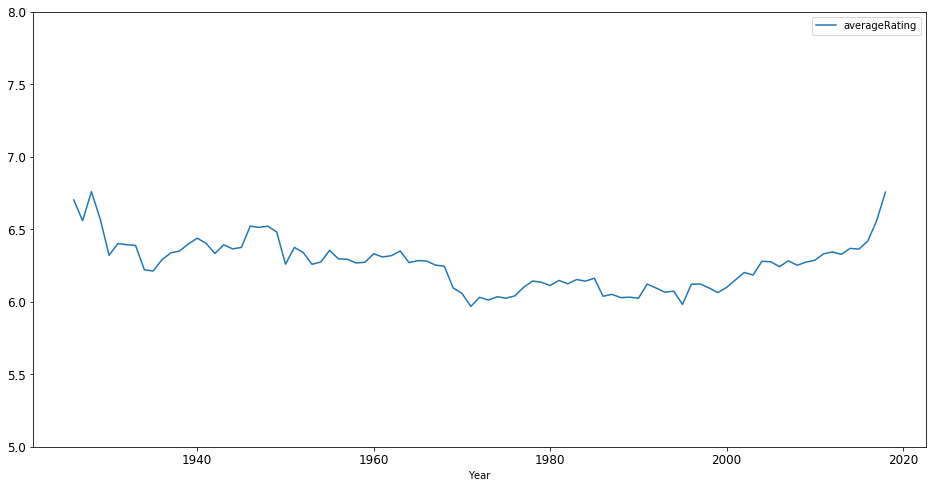

In [6]:
#let's look at average ratings by year and average ratings by year by genre
df_year_ratings = df_IMDB_agg[['startYear','primaryTitle','averageRating','numVotes']].groupby(['startYear'], as_index=True).mean()
df_year_ratings_last100 = df_year_ratings[-101:-1]

def line_graph(df, y, x_label):
    a = df[[y]].plot(kind='line', figsize=(16,8), fontsize=12) #xticks=(np.arange(len(df_year_ratings_last100)), df.index.values
    a.set_xlabel(x_label, fontsize=10)
    a.set_ylim(ymin=5, ymax=8)
    plt.show()

def bar_graph(df, y, x_label):
    a = df[[y]].plot(kind='bar', figsize=(16,8), fontsize=12)
    a.set_xlabel(x_label, fontsize=12)
    plt.show()
    
line_graph(df_year_ratings_last100, y='averageRating', x_label='Year')

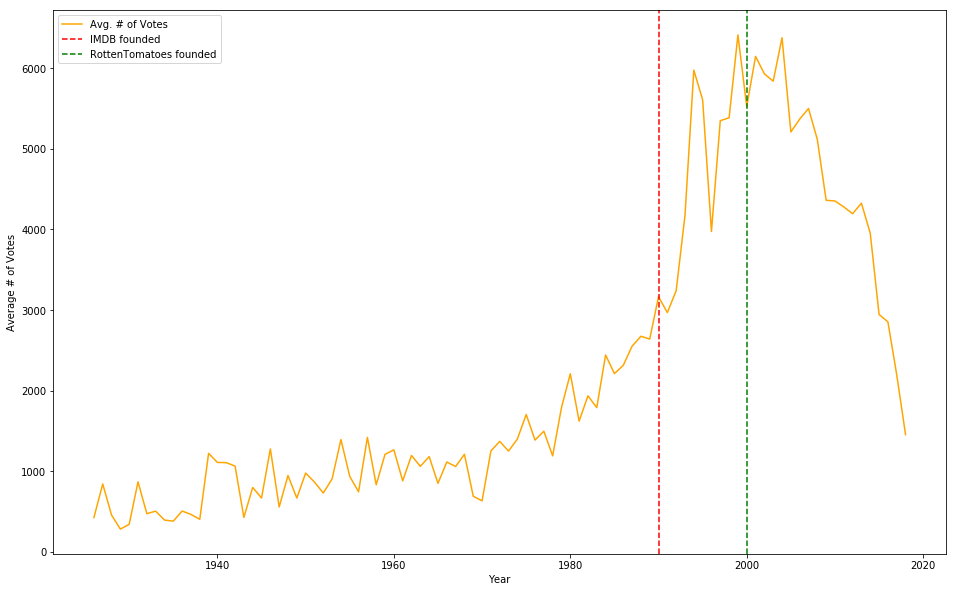

In [7]:
a = df_year_ratings_last100['numVotes'].plot(figsize=(16,10), label='Avg. # of Votes', color='orange')
a.set_xlabel('Year', fontsize=10)
a.set_ylabel('Average # of Votes')
plt.axvline(x=1990, color='red', linestyle='--', label='IMDB founded')
plt.axvline(x=2000, color='green', linestyle='--', label='RottenTomatoes founded')
plt.legend()
plt.show()

### Takeaways

Movie ratings have been on a decline ever since the 40s untl roughly the year 2000. Since 2000, we've seen a fairly large increase, especially within the last 2-3 years.  

I also plotted number of votes per year because I wanted to see if there was a volume issue. I thought that with more votes in recent years this could be skewing ratings upwards. Instead, it seems like the 'popularity' of films was steadily increasing during the slight down ratings period from the 1930s to the 1990s. Then all of a sudden we saw a massive influx in average number of votes which coincides with the increase in average ratings. However, the inverse relationship between ratings and average number of votes from ~2000 to the present is rather extreme. I wonder if the more average number of votes represents casual audience members who are less discerning and on average rate films higher. 

I would be very curious to isolate a consistent sample of people who have voted on films for the last 40-50 years and see how they score these films, i.e. if we control across the same audience are we better able to assess whether films are getting better or worse? 

In doing some external research, IMDB started around 1990, which coincides with the explosion on average number of votes per film on the graph. However, other ratings sites like Rotten Tomatoes and Metacritic started around 2000, which might explain the decline in average number of votes afterwards. It would be interesting to combine the three data sources (IDMB, RT, Metacritic) and see how the average number of votes per film has changed. It might also provide a more robust dataset of ratings because we may be missing certain audiences by only looking at IMDB.

## How are average IMDB ratings changing by genre?

In [8]:
df_years_genres = df_IMDB_agg[['startYear','genres','primaryTitle','directors','averageRating','numVotes']]
df_years_genres = df_years_genres[df_years_genres['genres'] != '\\N']

In [9]:
#create a unique list of genres from genres column in df above
list_genres = df_years_genres.genres.unique()
list_genre_split = []
for genre in list_genres:
    df_temp = genre.split(",")
    list_genre_split.append(df_temp)

df_genre_unq = pd.DataFrame(list_genre_split)
df_genre_unq.columns = ['genre_1', 'genre_2', 'genre_3']
list_genre_unq = pd.unique(df_genre_unq[['genre_1', 'genre_2', 'genre_3']].values.ravel('K'))
list_genre_unq_fil = list(filter(lambda x: type(x) == str, list_genre_unq))

In [10]:
#now I need to count the occurrences of each genre and average its rating and by year within df_IMDB_agg
#option 1 is to make a column for every genre and then count binary (this might be better to do averagerating)
for genre in list_genre_unq_fil:
    df_years_genres[genre] = df_years_genres.genres.apply(lambda x: genre in x).astype(int)    
df_years_genres.head()

,startYear,genres,primaryTitle,directors,averageRating,numVotes,Romance,Documentary,Biography,Drama,...,Musical,Sport,Family,Film-Noir,Adult,News,Game-Show,Reality-TV,Talk-Show,Short
0,1894,Romance,Miss Jerry,nm0085156,5.5,67.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1897,"Documentary,News,Sport",The Corbett-Fitzsimmons Fight,nm0714557,5.2,259.0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,1900,"Biography,Drama",Soldiers of the Cross,"nm0675140,nm0095714",6.2,35.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1906,"Biography,Crime,Drama",The Story of the Kelly Gang,nm0846879,6.3,464.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,1907,Drama,Robbery Under Arms,nm0533958,5.1,13.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Use the below to see the most highly rated film for a specific genre

In [11]:
#choose the genre first
df_genre_specific = df_years_genres[(df_years_genres['Horror']==1) & (df_years_genres['numVotes']>10000)].sort_values('averageRating', ascending=False)
df_genre_specific.head(10)

,startYear,genres,primaryTitle,directors,averageRating,numVotes,Romance,Documentary,Biography,Drama,...,Musical,Sport,Family,Film-Noir,Adult,News,Game-Show,Reality-TV,Talk-Show,Short
184986,2005,"Documentary,Horror",Earthlings,nm0598671,8.7,15276.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39570,1960,"Horror,Mystery,Thriller",Psycho,nm0000033,8.5,503525.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57202,1979,"Horror,Sci-Fi",Alien,nm0000631,8.5,675675.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59150,1980,"Drama,Horror",The Shining,nm0000040,8.4,730067.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
347679,2014,"Drama,Horror,Mystery",The Blue Elephant,nm1441566,8.2,21005.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4493,1920,"Fantasy,Horror,Mystery",The Cabinet of Dr. Caligari,nm0927468,8.1,46842.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9869,1926,"Drama,Fantasy,Horror",Faust,nm0003638,8.1,11988.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
41585,1962,"Drama,Horror,Thriller",What Ever Happened to Baby Jane?,nm0000736,8.1,42700.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
61397,1982,"Horror,Mystery,Sci-Fi",The Thing,nm0000118,8.1,311501.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33670,1955,"Crime,Drama,Horror",Diabolique,nm0167241,8.1,53395.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


I've created a floor based on number of votes greater than 10k. It's interesting to note that if you allow for all films to be included regardless of popularity, you introduce a lot of noise into the analysis. There are films such as 'Red Forrest' in 'Horror' which have quite a few number of votes, but when you look at the actual data there is a significant number of votes with a rating of 10, but very few actual comments. My theory is that there is some form of voting manipulation occurring. Films paying for voters to rate the film highly.

It would be interesting to isolate these smaller films with large disparities in the average and the mode to see if their ratings are fake. I would like to try and determine if I drill down on the ratings by reviewer could I predict or determine which reviews are fake? For example, the below is the top review for Red Forrest in IMDB which seems to imply there are a lot of fake reviews with a rating of 10 for the movie.

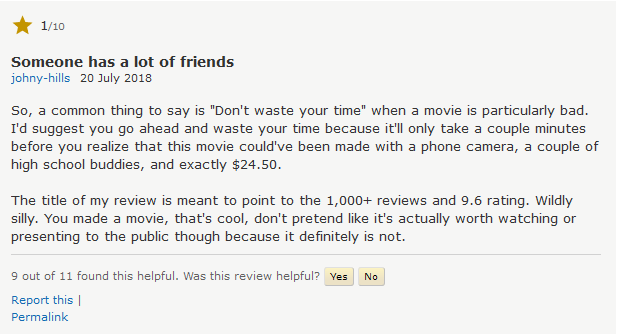

### Average rating by genre for all genres

In [12]:
genre_dict = {}
for genre in list_genre_unq_fil:
    df_temp = df_years_genres[df_years_genres[genre] == 1]
    df_temp = df_temp[['averageRating', 'numVotes']].mean()
    genre_dict[genre] = df_temp.to_dict()

df_genres_count = pd.DataFrame(genre_dict).T
df_genres_count = df_genres_count.sort_values('averageRating', ascending=False)

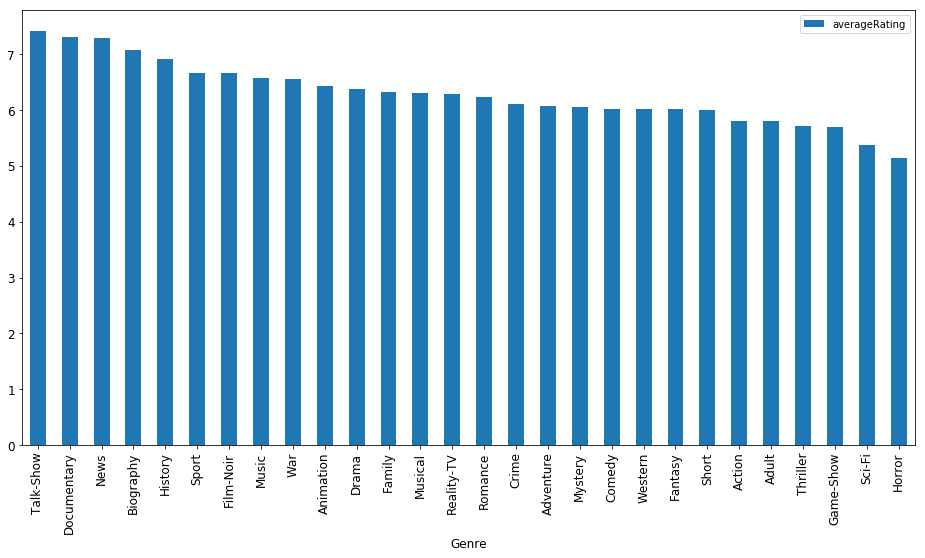

In [13]:
a = bar_graph(df_genres_count, 'averageRating', 'Genre')
plt.show()

### Ratings distribution for Sci-Fi films

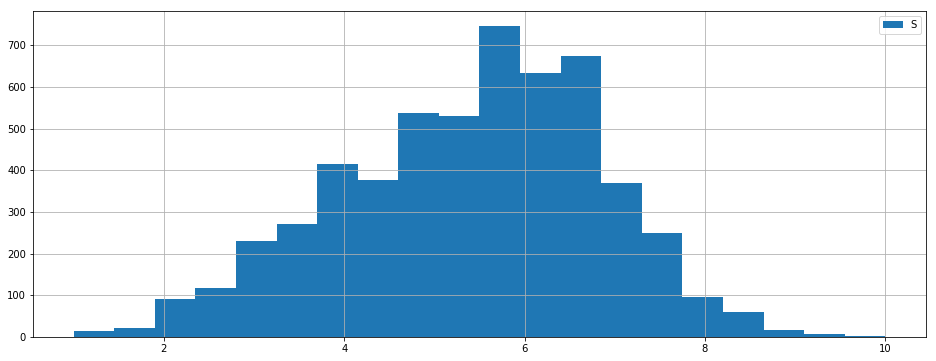

In [14]:
# df_years_genres[df_years_genres['Action']==1]['averageRating'].hist(bins=20, figsize=(16, 8))
# df_years_genres[df_years_genres['Drama']==1]['averageRating'].hist(bins=20)
# df_years_genres[df_years_genres['Horror']==1]['averageRating'].hist(bins=20)
# df_years_genres[df_years_genres['Fantasy']==1]['averageRating'].hist(bins=20)
a = df_years_genres[df_years_genres['Sci-Fi']==1]['averageRating'].hist(bins=20, figsize=(16, 6))
plt.legend(labels='SciFi')
plt.show()

It's interesting to see the long tail pulling down the mean for most of these genres. If you isolate Sci-Fi it's interesting to see how distributed the ratings are. As a huge fan of Sci-Fi, it's a little sad to see so much disparity from the mean, i.e. quality is all over the place. 

In terms of seeing how the low long tail is pulling down the mean, you can see this in action. The mean is ~5.8, but based on the histogram the mode is higher at ~6.5. The mean for Sci-Fi is 5.3 while the mode is closer to 6 with a close second mode of almost 7. The long tail of Sci-Fi films is really pulling the mean down from its mode.

### Ratings distribution for Documentary films

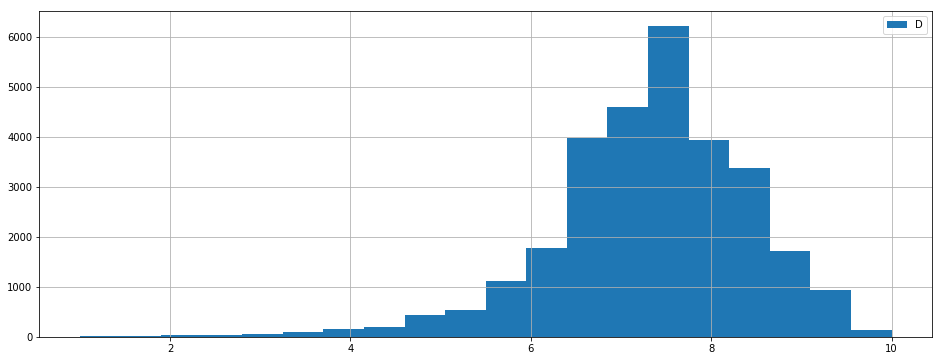

In [15]:
# histogram specifically for documentary films as it's the highest rated
df_years_genres[df_years_genres['Documentary']==1]['averageRating'].hist(bins=20, figsize=(16,6))
plt.legend('Documentary')
plt.show()

In [16]:
#df_years_genres[df_years_genres['Documentary']==1]['averageRating'].describe()

Finally, I'm not surprised to see Documentary as one of the highest rated genres, with its mean and mode very similar. It has a lot less of a tail and is concentrated within 1 standard deviation of its mean. I'm not really considering 'Talk-Shows' much in this analysis, focusing on 'Documentary', because the sample size for 'Talk-Shows' is very small (n=6).

### Which are the most popular genres based on average number of votes?

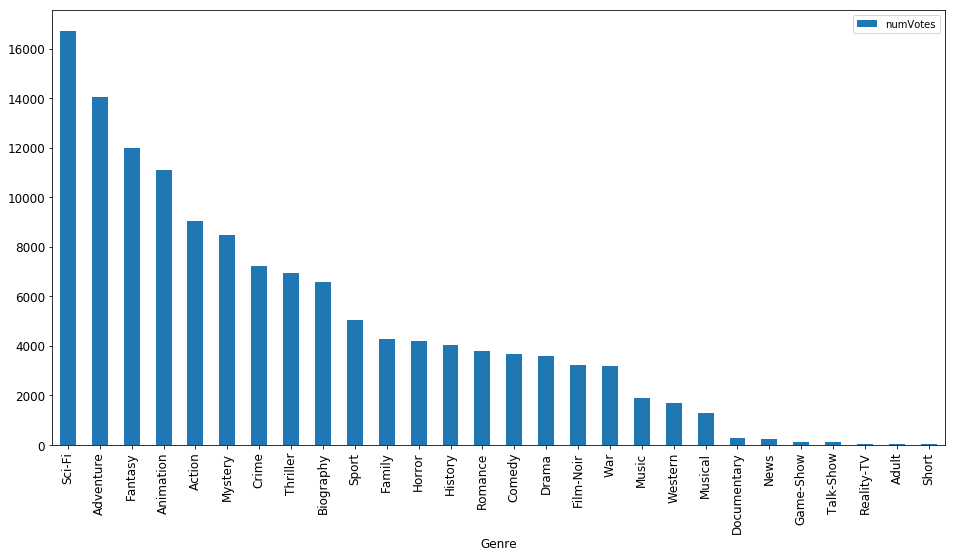

In [17]:
# look at number of votes by genre for all time
df_genres_count_votes = df_genres_count.sort_values('numVotes', ascending=False)
bar_graph(df_genres_count_votes, 'numVotes', 'Genre')

Despite the fact that Sci-Fi is the second worst rated genre, it is the most popular in terms of average number of votes for its films. However, this measure of popularity does seem to make sense with Sci-Fi, Adventure, Fantasy, Animation and Action being the top options. I would say this section is less surprising than the 'averageRating' graph.

### How are IMDB ratings changing by year for some of the more popular genres?

In [18]:
# look and see if drama (most popular genre according to stand-alone) is improving or getting worse
df_drama = df_years_genres[df_years_genres['Drama'] == 1]
df_drama_ratings = df_drama.groupby(['startYear']).mean()
df_drama_ratings_last100 = df_drama_ratings[-101:-1]

In [19]:
# look and see if Action / Adventure is improving or getting worse
df_act_adv = df_years_genres[(df_years_genres['Action'] == 1) | (df_years_genres['Adventure'] == 1)]
df_act_adv_ratings = df_act_adv.groupby(['startYear']).mean()
df_act_adv_ratings_last100 = df_act_adv_ratings[-101:-1]

In [20]:
# look and see if comedy is improving or getting worse
df_comedy = df_years_genres[df_years_genres['Comedy'] == 1]
df_comedy_ratings = df_comedy.groupby(['startYear']).mean()
df_comedy_ratings_last100 = df_comedy_ratings[-101:-1]

In [21]:
# look and see if Sci-Fi is improving or getting worse
df_scififantasy = df_years_genres[(df_years_genres['Sci-Fi'] == 1) | (df_years_genres['Fantasy'] == 1)]
df_scififantasy_ratings = df_scififantasy.groupby(['startYear']).mean()
df_scififantasy_ratings_last100 = df_scififantasy_ratings[-101:-1]

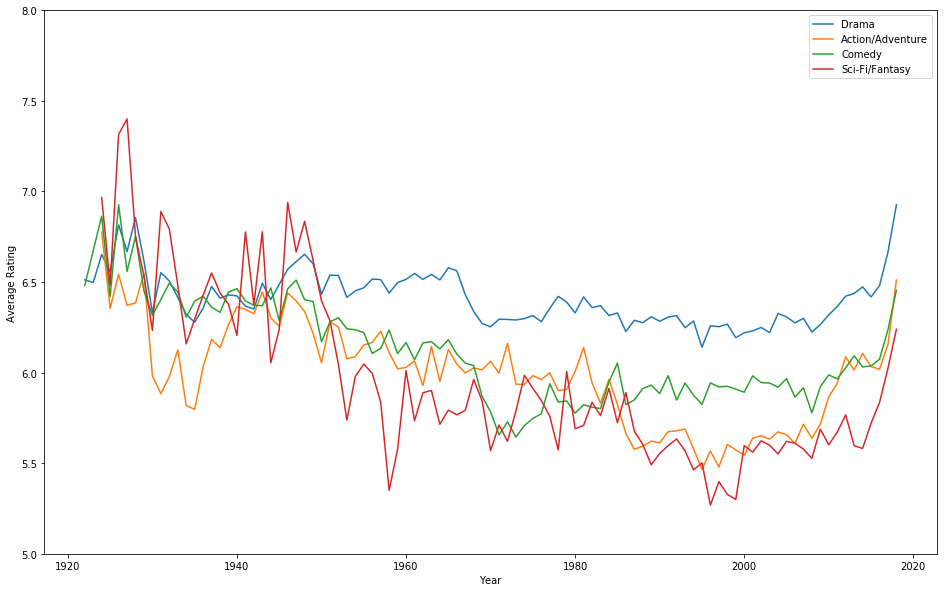

In [22]:
fig=plt.figure(figsize=(16,10))
plt.plot(df_drama_ratings_last100.index,df_drama_ratings_last100['averageRating'],label='Drama')
plt.plot(df_act_adv_ratings_last100.index,df_act_adv_ratings_last100['averageRating'], label='Action/Adventure')
plt.plot(df_comedy_ratings_last100.index,df_comedy_ratings_last100['averageRating'], label='Comedy')
plt.plot(df_scififantasy_ratings_last100.index,df_scififantasy_ratings_last100['averageRating'],label='Sci-Fi/Fantasy')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.ylim(ymin=5,ymax=8)
plt.legend()
plt.show()

### Takeaways

It's interesting how the genres above all exhibit increases within the last 15 or so years. The most drastic turnaround seems to be Sci-Fi / Fantasy, and as a fan, one can't hope that could mean the Sci-Fi and Fantasy genres are headed for some improvement in the overall ratings. However, drama is the most consistent with the lowest decline from the 40s to 00s.  It also seems to be the best time for drama films as, according to the graph, we've reached new highs in drama ratings. 

## Who are the most popular directors?
#### First, we'll start with ranking the 50 most popular directors (based on number of total votes on their films)

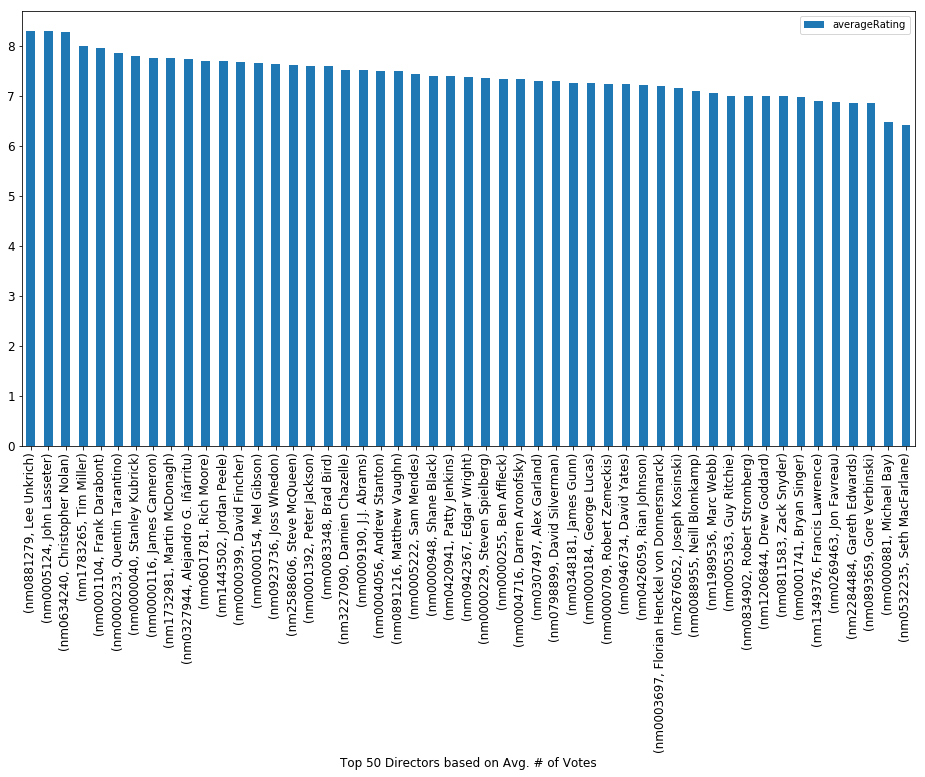

In [23]:
# top 50 directors by rating
df_dir = df_IMDB_agg[['startYear','primaryTitle','directors','primaryName','averageRating', 'numVotes']]
df_dir_ratings = df_dir.groupby(['directors','primaryName'], as_index=True).mean()
df_dir_ratings = df_dir_ratings.sort_values(['numVotes'], ascending=False)
# only look at top 50 based on number of average number of votes per film
df_dir_ratings_top50 = df_dir_ratings[:51].sort_values(['averageRating'], ascending=False)

#graph the top50 result using graphing function 
bar_graph(df_dir_ratings_top50, y='averageRating', x_label ='Top 50 Directors based on Avg. # of Votes')

This graph shows the average rating in descending order for the most popular directors (based on average number of votes). Lee Unkrich is a little surprising here (I don't recognize the name, not like some of the others) until you research that he's the director behind quite a few Pixar titles like Toy Story 2 and 3, Coco, Monsters, Inc., etc. The other names like Lasseter, Nolan, Miller make a lot of sense.  

It's interesting to see who makes the cut and how some of the names that are recognizable like Christopher Nolan and Stanley Kubrick compare to each other according to IMDB ratings. 

#### Distribution of all directors' ratings

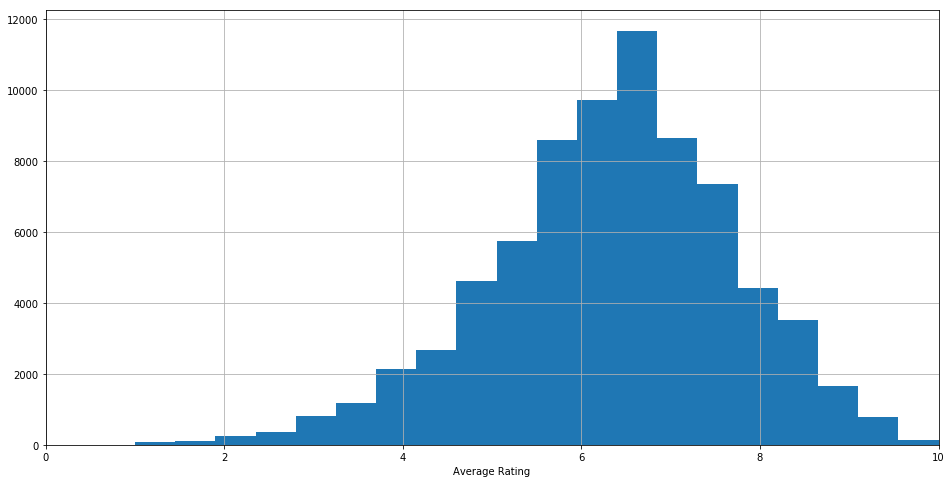

In [24]:
# distribution of directors by average rating
df_dir_ratings_2 = df_dir.groupby(['directors','primaryName'], as_index=False).mean()
df_dir_ratings_2['averageRating'].hist(bins=20,figsize=(16,8))
plt.xlim(xmin=0, xmax=10)
plt.xlabel('Average Rating')
plt.show()

#### Distribution of the top 100 most popular directors

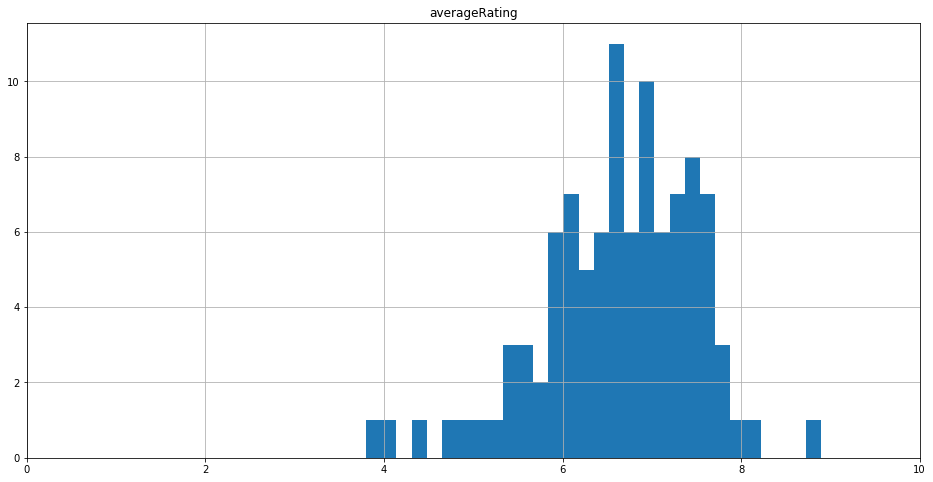

In [26]:
#distribution of top 100 directors
a_top50 = df_dir_ratings_2[:101].hist('averageRating', bins=30, figsize=(16,8))
plt.xlim(xmin=0, xmax=10)
plt.show()

There is much more consistency with the top 50 most popular directors. However, whereas the mode is above the mean for the entire director population, which kind of makes sense as you would expect a lot of directors who pull the mean down, the mode is actually below the mean for the top 50 directors (6.5 mode versus 6.8 mean). This suggests that some of the most popular directors are pulling the ratings up. So not only are most popular directors getting the most traffic, but they're also more highly rated than the average population. 

### How does a director's experience relate to ratings?

In [27]:
#change df_years_genres to remove \N
df_years_genres_dir = df_dir[df_dir['directors'] != '\\N']

def rank_directors(df, group_col, sort_col):
    df['Rank'] = df.sort_values(sort_col, ascending=True) \
             .groupby(group_col) \
             .cumcount() + 1
    return df

df_dir_rank = rank_directors(df_years_genres_dir, 'directors', 'startYear').sort_values(['directors', 'startYear'])

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


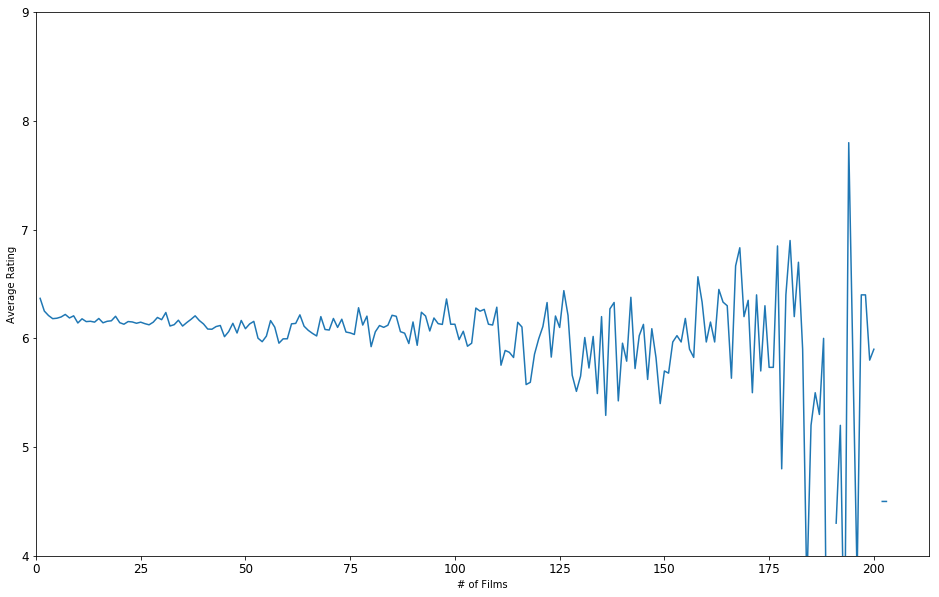

In [95]:
#graph new dataframe to determine if ranking increases with number of films released
df_dir_rank_ratings = df_dir_rank.groupby(['Rank'], as_index=True).mean()
   
def dir_graph(df, y, x_label):
    a = df[y].plot(kind='line', figsize=(16,10), fontsize=12)
    a.set_xlabel(x_label, fontsize=10)
    a.set_ylabel('Average Rating', fontsize=10)
    a.set_xlim(xmin=0)
    a.set_ylim(ymin=4, ymax=9)
    plt.show()

dir_graph(df_dir_rank_ratings, 'averageRating', '# of Films')

### Takeaways
Surprisingly, for all directors, the average rating decreases slightly with more experience. Even more surprising, there seems to be a sharp drop after a directors first film before it levels off to a more gradual decline. There is a lot more noise in the data greater than 150 films probably due to the lower number of directors who make that many films.

For the top 50 directors, the first thing you notice is a lot more volatility than the overall population. We still seem to see a slight decline in ratings with more experience, although it is harder to tell given the volatility. However, if we look at the top 100 directors we remove some of the volatility and start to see an increase in ratings with more experience. For both top 50 and top 100 directors by average number of votes per film, the mean rating is much higher than the overall population so there is some correlation between popularity and ratings.

Not pictured here, but if you start to look at the top 200 or top 300 directors by popularity, the 'ratings to experience' curve above starts to look more like the total population (i.e. a decrease in ratings with more experience).

#### What about the top 100 most popular directors?

In [96]:
# df_dir_ratings_top100_2 = df_dir_ratings_2[:101]
# df_dir_ratings_top100_2

# #list with top100 directors
# dir_top100 = df_dir_ratings_top100_2.directors.unique()
# df_dir_ratings_top100_3 = df_dir_rank[df_dir_rank['directors'].isin(dir_top100)]
# df_dir_rank_ratings_top100 = df_dir_ratings_top100_3.groupby(['Rank'], as_index=True).mean()

# dir_graph(df_dir_rank_ratings_top100, 'averageRating', '# of Films/TV shows from Top 100 Directors ')

### Logarithmic scale for Director Ratings and Average Number of Votes

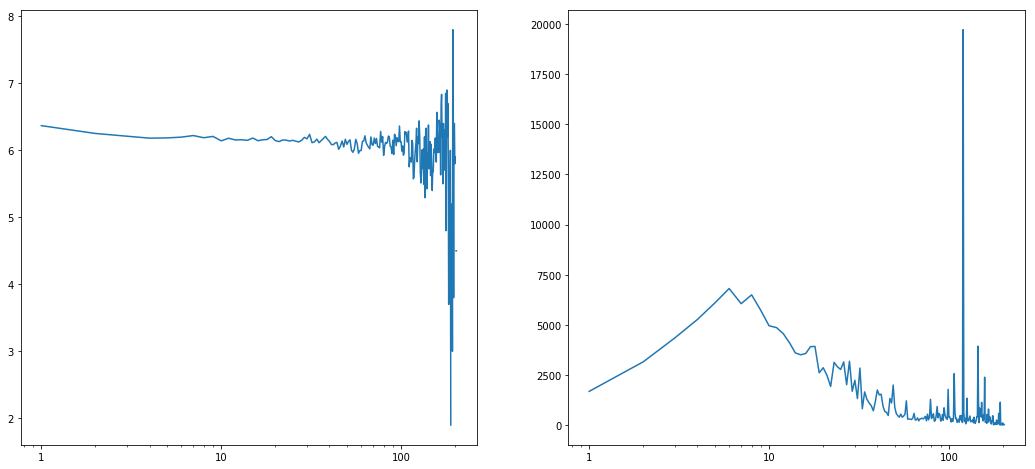

In [97]:
plt.figure(figsize=(18,8))
ax = plt.subplot(1,2,1)
plt.plot(df_dir_rank_ratings.index,df_dir_rank_ratings['averageRating'].values)
plt.xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1 = plt.subplot(1,2,2)
plt.plot(df_dir_rank_ratings.index,df_dir_rank_ratings['numVotes'].values)
plt.xscale('log')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

#### Directors with greater than 175 films is a small group

In [91]:
df_dir_rank[df_dir_rank['Rank']> 175].groupby(['primaryName']).mean()

,startYear,averageRating,numVotes,Rank
primaryName,,,,
Jirô Yoshino,1924.328358,NaN,NaN,209.0
Kinya Ogawa,2003.666667,NaN,NaN,193.5
Minoru Inao,2007.454545,7.550000,11.500000,181.0
Sam Newfield,1951.107143,5.403846,121.115385,189.5
Satoru Kobayashi,2000.428571,NaN,NaN,182.5
Shirô Nakagawa,1936.000000,NaN,NaN,176.5
William Beaudine,1966.000000,3.200000,1265.000000,176.0
Wui Ng,1969.526316,NaN,NaN,185.0


The volatility for the end of the director experience graph is because there aren't many directors who have made that many films. Quite a few look to be Japanese, but there's not a lot of information on IMDB for their titles. Sam Newfield looks to have been a prolific 'Western' director. Some further digging into these specific directors could tell us why so few have made so many films or how they were able to make so many when almost all other directors make less than 100 films.

## Propose further research:
1. Look at ratings by production / distribution company: <br>
    a. Which companies are improving / declining their content?<br>
    b. Theatrical versus streaming production companies - which is producing on average better content for consumers?<br><br>
2. Compare average consumer ratings to theatrical box office metrics<br>
    a. Do ratings correlate to box office success?<br>
    b. Do average ratings scores for a studio correlate to more box office<br>
    c. Does increasing ratings lead to increased box offfice YOY?<br><br>
3. Identify genre opportunities<br>
    a. Determine under-served genres based on high ratings but low number of ratings<br>
    b. Determine over-served genres with high number of ratings but low actual ratings <br><br>
4. Combine IMDB, RottenTomatoes, and Metacritic reviews together
    a. Are number of votes per film constant from the 1990s era from IMDB, i.e. competition in ratings sites dispersed users
    b. Create a better picture of user ratings by combining all of the sites
    c. Compare the difference in audiences who rate on IMDB versus other competitive sites